## Load Packages

In [1]:
# Link to Drive
from google.colab import drive
drive.mount('/content/drive')

# Connect to Earth Engine
import ee
ee.Authenticate()
ee.Initialize()

Mounted at /content/drive
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=CEDsbCqA6JpidoEF_Ctyq-8PA9pjxrZgn9SX23Alw9w&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWgldj7AYzDNdJMUDa0qLoxNXCq1YteWSXd-7KEkqdSyfbK-L12oB14

Successfully saved authorization token.


In [2]:
#!pip install wxee
!pip install rioxarray 
!pip install geopandas
import os
from glob import glob
import pandas as pd
#import wxee
import xarray as xr
import rioxarray as rio
import geopandas as gpd
import numpy as np

     |████████████████████████████████| 46 kB 2.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 19.3 MB 7.2 MB/s 
     |████████████████████████████████| 6.3 MB 26.2 MB/s 
  Created wheel for rioxarray: filename=rioxarray-0.9.0-py3-none-any.whl size=54395 sha256=74363c82757e87c4875f904cabdeeed75b811d621836bb84acb077673ae8bc43
  Stored in directory: /root/.cache/pip/wheels/f2/0d/f2/29da7ed804b71eb1317c3683b373f59d7c0c4c501117f2b144
Successfully built rioxarray
     |████████████████████████████████| 1.0 MB 7.8 MB/s 
     |████████████████████████████████| 15.4 MB 56.1 MB/s 


## Processing in GEE

### Client-side Functions

In [ ]:
# Function to Mask Clouds
def maskCloud(image):
  cloudMask = image.select(['pixel_qa']).bitwiseAnd(1<<5).eq(0)
  cloudShadowMask = image.select(['pixel_qa']).bitwiseAnd(1<<3).eq(0)
  final_mask = cloudMask.And(cloudShadowMask)
  return image.updateMask(final_mask)

In [ ]:
# Function of ostu's method
def otsu(histogram):
    counts = ee.Array(ee.Dictionary(histogram).get('histogram'))
    means = ee.Array(ee.Dictionary(histogram).get('bucketMeans'))
    size = means.length().get([0])
    total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
    sum = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])
    mean = sum.divide(total)

    indices = ee.List.sequence(1, size)

    def iFunc(i):
      aCounts = counts.slice(0, 0, i) 
      aCount = aCounts.reduce(ee.Reducer.sum(), [0]).get([0])
      aMeans = means.slice(0, 0, i)
      aMean = aMeans.multiply(aCounts).reduce(ee.Reducer.sum(),[0]).get([0]).divide(aCount)
      bCount = total.subtract(aCount)
      bMean = sum.subtract(aCount.multiply(aMean)).divide(bCount)
      return aCount.multiply(aMean.subtract(mean).pow(2)) \
            .add(bCount.multiply(bMean.subtract(mean).pow(2)))

    # Compute between sum of squares, where each mean partitions the data
    bss = indices.map(iFunc)

    return means.sort(bss).get([-1])

In [ ]:
# Function of Otsu's Method
def thresholding(image):
  
  waterIndex = index

  #Compute the histogram of the NIR band. (the mean and variance are only FYI)
  histogram = image.select([index]).reduceRegion(
      reducer = ee.Reducer.histogram(255,2).combine('mean', None, True).combine('variance', None, True),
      geometry = roi.getInfo(),
      scale = 30,
      bestEffort = True)
  
  threshold = otsu(histogram.get(index+'_histogram'))
  water = image.select([index]).lt(threshold)
  return water.rename(['watermask']) \
              .clip(roi) \
              .copyProperties(image) \
              .set('system:time_start', ee.Date.fromYMD(image.get('year'), 12, 31))

In [ ]:
# Function to Visualize
import folium

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'
print('Folium version: ' + folium.__version__)


# Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

Folium version: 0.8.3


### Define ROI

In [ ]:
# Thailand
roi = ee.Geometry.Polygon(
        [[99.18087250062585, 9.293202617724758],
          [99.18087250062585, 9.161172665389476],
          [99.32404941152667, 9.161172665389476],
          [99.32404941152667, 9.293202617724758]], None, False)
# Vietnam
#roi = ee.Geometry.Polygon(
#    [[106.78004287743515, 20.141486311357436],
#     [106.78004287743515, 21.60942331713715],
#     [108.00327879982069, 21.60942331713715],
#     [108.00327879982069, 20.141486311357436]], None, False)
roi.getInfo()

{'coordinates': [[[99.18087250062585, 9.161172665389476],
   [99.32404941152667, 9.161172665389476],
   [99.32404941152667, 9.293202617724758],
   [99.18087250062585, 9.293202617724758],
   [99.18087250062585, 9.161172665389476]]],
 'geodesic': False,
 'type': 'Polygon'}

### Load Data

In [ ]:
# Load Satellitie Archive
ls8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") \
        .filterDate('2013', '2020') \
        .select(['B2', 'B3', 'B4', 'B5', 'B6', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir', 'pixel_qa']) \
        .filterBounds(roi).sort("system:time_start", True)
ls7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR") \
      .filterDate('1999', '2020') \
      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir', 'pixel_qa']) \
      .filterBounds(roi).sort("system:time_start", True)
ls5 = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR") \
      .filterDate('1984', '2013') \
      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir', 'pixel_qa']) \
      .filterBounds(roi).sort("system:time_start", True)
ls4 = ee.ImageCollection("LANDSAT/LT04/C01/T1_SR") \
      .filterDate('1984', '1994') \
      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir', 'pixel_qa']) \
      .filterBounds(roi).sort("system:time_start", True)

ls_all = ls8.merge(ls7).merge(ls5).merge(ls4) \
        .sort('system:time_start', True)
print(ls_all.size().getInfo())        

640


### Mask Clouds

In [ ]:
ls_cloudless = ls_all.map(maskCloud)
print(ls_cloudless.size().getInfo())

640


### Reduce by Year

In [ ]:
years = ee.List.sequence(1984, 2019)
ls_Treduced = ee.ImageCollection.fromImages(
    years.map(lambda YEAR: ls_cloudless.filter(ee.Filter.calendarRange(YEAR, YEAR, 'year')) \
                          .median() \
                          .clip(roi) \
                          .set({'year': YEAR, 'system:time_start': ee.Date.fromYMD(YEAR, 12, 31)})))
print(ls_Treduced.size().getInfo())

36


### Filter out years where no data available

In [ ]:
# Add "bandlength" as new property
ls_filtered = ls_Treduced.map(lambda image: image.set('bandlength', image.bandNames().size()))
# Filter out the years where no data are available
ls_filtered = ls_filtered.filterMetadata('bandlength', 'not_equals', 0)
print(ls_filtered.size().getInfo())

33


In [ ]:
list_A = ls_filtered.toList(ls_filtered.size())
image_A = ee.Image(list_A.get(-1)).clip(roi)
falseColor_id = image_A.getMapId({'min': 0, 'max': 2550,
                           'bands':['nir', 'red', 'green']})

centroid = roi.bounds().getInfo()['coordinates'][0][0]
centroid = [centroid[1], centroid[0]]

Mapdisplay(centroid, {'False Color Composite':falseColor_id}, zoom_start=12)

### Water Segmentation with Otsu

In [ ]:
index = 'nir'
ls_wmsk = ls_filtered.map(thresholding)
print(ls_wmsk.size().getInfo())

33


In [ ]:
list_B = ls_wmsk.toList(ls_wmsk.size())
image_B = ee.Image(list_B.get(-1)).clip(roi)
image_B = image_B.mask(image_B)
watermask_id = image_B.getMapId({'palette':'blue'})

Mapdisplay(centroid, {'False Color Composite':falseColor_id,
                      'Water Mask': watermask_id}, zoom_start=11)

### Clip to ROI

In [ ]:
ls_clipped = ls_wmsk.map(lambda image: image.clip(roi))
print(ls_clipped.size().getInfo())

33


In [ ]:
#ls_clipped.first().getInfo()

### Export to Drive

In [ ]:
#img_clipped = ls_clipped.toBands()#.clip(roi)
#print(img_clipped.getInfo())

In [ ]:
#task_config = {
#    'description': 'test_otsu',
#    'fileNamePrefix': 'test_otsu_big',
#    'crs': 'EPSG:4326',
#    'scale': 30,  
#    'region': roi.getInfo()['coordinates'],
#    'folder': 'myExportImage',
#    'skipEmptyTiles': True,
#    'fileFormat': 'GeoTIFF',
#    'maxPixels': 10e12
#    }
#task = ee.batch.Export.image.toDrive(img_clipped, **task_config)
#task.start() 

In [ ]:
#task.status()

## Processing in Python

### Clean up dataset

In [3]:
wdir = '/content/drive/My Drive/myExportImage/'
path_images = glob(os.path.join(wdir,'*.tif'))
path_images

['/content/drive/My Drive/myExportImage/test_otsu.tif',
 '/content/drive/My Drive/myExportImage/test_otsu_big.tif',
 '/content/drive/My Drive/myExportImage/predict_2019.tif',
 '/content/drive/My Drive/myExportImage/reference_2019.tif']

In [53]:
# Load GeoTiff into Xarray
xda = rio.open_rasterio(path_images[0])
xda = xda.rename({'band':'time'})

xds = xda.to_dataset(name="watermask")
xds

<xarray.Dataset>
Dimensions:      (time: 33, x: 532, y: 491)
Coordinates:
  * time         (time) int64 1 2 3 4 5 6 7 8 9 ... 25 26 27 28 29 30 31 32 33
  * x            (x) float64 99.18 99.18 99.18 99.18 ... 99.32 99.32 99.32 99.32
  * y            (y) float64 9.293 9.293 9.293 9.292 ... 9.162 9.162 9.161 9.161
    spatial_ref  int64 0
Data variables:
    watermask    (time, y, x) uint8 ...

In [54]:
# Pair up Index and Years
keys = [str(i) for i in range(36)]
#years = pd.date_range(start='1984', end='2020', freq='Y')
years = [i for i in range(1984,2020)]
pair = dict([[i,j] for i,j in zip(keys, years)])
print(pair)

{'0': 1984, '1': 1985, '2': 1986, '3': 1987, '4': 1988, '5': 1989, '6': 1990, '7': 1991, '8': 1992, '9': 1993, '10': 1994, '11': 1995, '12': 1996, '13': 1997, '14': 1998, '15': 1999, '16': 2000, '17': 2001, '18': 2002, '19': 2003, '20': 2004, '21': 2005, '22': 2006, '23': 2007, '24': 2008, '25': 2009, '26': 2010, '27': 2011, '28': 2012, '29': 2013, '30': 2014, '31': 2015, '32': 2016, '33': 2017, '34': 2018, '35': 2019}


In [80]:
# Get the index of loaded image
xda.attrs['long_name'][0].split('_')[0]
imgID = [i.split('_')[0] for i in xda.attrs['long_name']]
print(imgID)

# Get years based on index
t = [pair[i] for i in imgID]
print(t)

['3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35']
[1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


In [58]:
# Replace "index" coordinates with "year" coordinates
xds.coords['time'] = np.array(t)
xds

<xarray.Dataset>
Dimensions:      (time: 33, x: 532, y: 491)
Coordinates:
  * time         (time) int64 1987 1988 1989 1990 1991 ... 2016 2017 2018 2019
  * x            (x) float64 99.18 99.18 99.18 99.18 ... 99.32 99.32 99.32 99.32
  * y            (y) float64 9.293 9.293 9.293 9.292 ... 9.162 9.162 9.161 9.161
    spatial_ref  int64 0
Data variables:
    watermask    (time, y, x) uint8 ...

TypeError: ignored

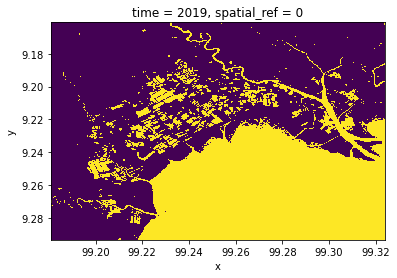

In [79]:
# Map
xds.watermask.sel(time=2019).plot()
#xds.watermask.plot(robust=True, col="time", col_wrap=3)

### Match watermask and pond layer

In [84]:
# Load Pond layer
path_ponds = '/content/drive/My Drive/THESIS_AQUAPONDS/ROI/Aquaculture_Asia_Coast_2019/Aquaculture_ponds_Asian_coast_2019/ponds_by_country/pond_2019_Thailand.gpkg'

# Load Ponds of one country
ponds_tha = gpd.read_file(path_ponds)
ponds_tha.head()

,id,index_right,GID_0,NAME_0,geometry
0,845046,13,THA,Thailand,"MULTIPOLYGON (((97.63223 8.57424, 97.63223 8.5..."
1,845047,13,THA,Thailand,"MULTIPOLYGON (((97.63771 8.65904, 97.63771 8.6..."
2,845048,13,THA,Thailand,"MULTIPOLYGON (((97.63879 8.59248, 97.63879 8.5..."
3,845049,13,THA,Thailand,"MULTIPOLYGON (((97.64238 8.57253, 97.64238 8.5..."
4,845050,13,THA,Thailand,"MULTIPOLYGON (((97.85977 9.39629, 97.85977 9.3..."


### Transfer to xarray using wxee

In [ ]:
# Export Image using wxee
#xdr = ls_clipped.wx.to_xarray(path='/content/drive/My Drive/myExportImage/test_otsu.nc', scale=30)

In [ ]:
wdir = '/content/drive/My Drive/myExportImage/'
path_images = glob(os.path.join(wdir,'*.nc'))
path_images

['/content/drive/My Drive/myExportImage/test_otsu.nc']

In [ ]:
xda = rio.open_rasterio(path_images[0])#.astype("uint8")
xda

<xarray.DataArray 'watermask' (time: 33, y: 491, x: 532)>
[8619996 values with dtype=float64]
Coordinates:
  * time         (time) object 1987-12-31 00:00:00 ... 2019-12-31 00:00:00
  * x            (x) float64 99.18 99.18 99.18 99.18 ... 99.32 99.32 99.32 99.32
  * y            (y) float64 9.293 9.293 9.293 9.292 ... 9.162 9.162 9.161 9.161
    spatial_ref  int64 0
Attributes: (12/13)
    AREA_OR_POINT:           Area
    crs:                     +init=epsg:4326
    is_tiled:                1
    nodatavals:              -32768
    offsets:                 0
    res:                     [0.00026949 0.00026949]
    ...                      ...
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              nan
    scale_factor:            1.0
    add_offset:              0.0

In [ ]:
xds = xda.to_dataset(name='watermask')
xds

<xarray.Dataset>
Dimensions:      (time: 33, x: 532, y: 491)
Coordinates:
  * time         (time) object 1987-12-31 00:00:00 ... 2019-12-31 00:00:00
  * x            (x) float64 99.18 99.18 99.18 99.18 ... 99.32 99.32 99.32 99.32
  * y            (y) float64 9.293 9.293 9.293 9.292 ... 9.162 9.162 9.161 9.161
    spatial_ref  int64 0
Data variables:
    watermask    (time, y, x) float64 ...

In [ ]:
#xds.watermask.plot(robust=True, col="time", col_wrap=3)

## Accuracy Assessment

In [ ]:
from shapely import geometry
import gdal

### Subset to Predicted Layer 2019

In [ ]:
xds2019 = xds.isel(time=-1)
xds2019 = xds2019.fillna(0)
#xda2019 = xda[-1: ].interpolate_na(dim="x", method="nearest")
#xda2019 = xda2019.fillna(0)
#xda2019

In [ ]:
# Subset to Predicted Layer of 2019
wdir = '/content/drive/My Drive/myExportImage/'
xds2019.rio.to_raster(os.path.join(wdir, "predict_2019.tif"))

### Subset Reference Layer 2019 to ROI

In [ ]:
# Load ponds of one country
wdir = '/content/drive/MyDrive/THESIS_AQUAPONDS/ROI/Aquaculture_Asia_Coast_2019'
path_ponds = glob(os.path.join(wdir, 'Aquaculture_ponds_Asian_coast_2019', 'ponds_by_country', 'pond_2019_Thailand.gpkg'))[0]
#print(path_ponds)
ponds_one_country = gpd.read_file(path_ponds)
ponds_one_country.head()

,id,index_right,GID_0,NAME_0,geometry
0,845046,13,THA,Thailand,"MULTIPOLYGON (((97.63223 8.57424, 97.63223 8.5..."
1,845047,13,THA,Thailand,"MULTIPOLYGON (((97.63771 8.65904, 97.63771 8.6..."
2,845048,13,THA,Thailand,"MULTIPOLYGON (((97.63879 8.59248, 97.63879 8.5..."
3,845049,13,THA,Thailand,"MULTIPOLYGON (((97.64238 8.57253, 97.64238 8.5..."
4,845050,13,THA,Thailand,"MULTIPOLYGON (((97.85977 9.39629, 97.85977 9.3..."


In [ ]:
bbox = geometry.Polygon(
        [[99.18087250062585, 9.293202617724758],
          [99.18087250062585, 9.161172665389476],
          [99.32404941152667, 9.161172665389476],
          [99.32404941152667, 9.293202617724758]])

In [ ]:
ponds_subset = ponds_one_country[ponds_one_country.geometry.within(bbox)]
print(ponds_subset.shape)
ponds_subset.head()

(1701, 5)


,id,index_right,GID_0,NAME_0,geometry
30283,896716,13,THA,Thailand,"MULTIPOLYGON (((99.18101 9.27016, 99.18110 9.2..."
30287,896722,13,THA,Thailand,"MULTIPOLYGON (((99.18119 9.27079, 99.18137 9.2..."
30291,896729,13,THA,Thailand,"MULTIPOLYGON (((99.18227 9.21761, 99.18227 9.2..."
30299,896738,13,THA,Thailand,"MULTIPOLYGON (((99.18443 9.26172, 99.18443 9.2..."
30303,896742,13,THA,Thailand,"MULTIPOLYGON (((99.18479 9.26262, 99.18497 9.2..."


### Rasterize Reference Layer

reference: https://lpsmlgeo.github.io/2019-09-22-binary_mask/

alternative: https://towardsdatascience.com/use-python-to-convert-polygons-to-raster-with-gdal-rasterizelayer-b0de1ec3267

In [ ]:
import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
# Load Raster
wdir = '/content/drive/My Drive/myExportImage/'
raster_path = os.path.join(wdir, "predict_2019.tif")
with rasterio.open(raster_path, "r") as src:
    raster_img = src.read()
    raster_meta = src.meta

In [ ]:
# Load Vector
vct = ponds_subset

In [ ]:
# Verify that the raster and vector are having same CRS
print("CRS Raster: {}, CRS Vector {}".format(vct.crs, src.crs))

CRS Raster: epsg:4326, CRS Vector EPSG:4326


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  import sys


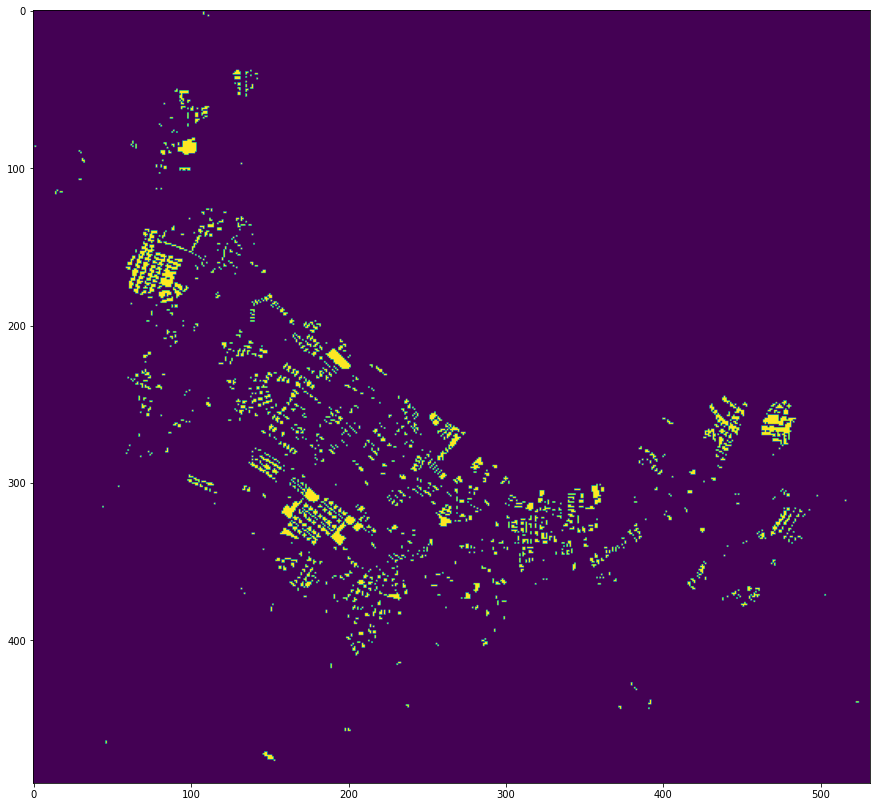

In [ ]:
# Generate Binary Mask

#Generate polygon
def poly_from_utm(polygon, transform):
    poly_pts = []
    
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # Convert polygons to the image CRS
        poly_pts.append(~transform * tuple(i))
        
    # Generate a polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# Generate Binary maks

poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in vct.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)

# Plot the mask

plt.figure(figsize=(15,15))
plt.imshow(mask)


In [ ]:
mask = mask.astype("uint16")
save_path = os.path.join(wdir, "reference_2019.tif")
bin_mask_meta = src.meta.copy()
bin_mask_meta.update({'count': 1})
with rasterio.open(save_path, 'w', **bin_mask_meta) as dst:
    dst.write(mask * 255, 1)



### Confusion Matrix

In [ ]:
#!pip install sklearn
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix

In [ ]:
wdir = '/content/drive/My Drive/myExportImage/'
da_pre19 = rio.open_rasterio(os.path.join(wdir, "predict_2019.tif"))
da_ref19 = rio.open_rasterio(os.path.join(wdir, "reference_2019.tif"))

In [ ]:
#da_pre19.isnull()==True
da_pre19 = da_pre19.astype("uint8")#.fillna(0)

In [ ]:
da_ref19 = da_ref19.astype("uint8")#.fillna(0)

In [ ]:
confusion_matrix(y_true=da_ref19, y_pred=da_pre19)

ValueError: ignored